# Sequence to Sequence Models for Timeseries Regression


In this notebook we are going to tackle a harder problem: 
- predicting the future on a timeseries
- by outputing sequence of predictions
- with rough uncertainty (uncalibrated)
- using forecasted information (like weather report, week, or cycle of the moon)

Not many papers benchmark movels for multivariate regression, much less seq prediction with uncertainty. So this notebook will try a range of models on a range of dataset.

We do this using a sequence to sqequence interface

<img src="../reports/figures/Seq2Seq for regression.png" />


- [ ] don't overfit
    - bejing data has a problem
    - Current?
- [ ] make overlap between past and future?
- [ ] do n=5 runs

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change. But blacklist large modules
%load_ext autoreload
%autoreload 2
%aimport -pandas
%aimport -torch
%aimport -numpy
%aimport -matplotlib
%aimport -dask
%aimport -tqdm
%matplotlib inline

In [2]:
# Imports
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
import torch
import torch.utils.data

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.auto import tqdm

import pytorch_lightning as pl

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
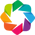

In [3]:
import holoviews as hv
from holoviews import opts
from holoviews.operation.datashader import datashade, dynspread
hv.extension('bokeh', inline=True)
from seq2seq_time.visualization.hv_ggplot import ggplot_theme
hv.renderer('bokeh').theme = ggplot_theme

# holoview datashader timeseries options
%opts RGB [width=800 height=200 show_grid=True active_tools=["xwheel_zoom"] default_tools=["xpan","xwheel_zoom", "reset", "hover"] toolbar="right"]
%opts Curve [width=800 height=200 show_grid=True active_tools=["xwheel_zoom"] default_tools=["xpan","xwheel_zoom", "reset", "hover"] toolbar="right"]
%opts Scatter [width=800 height=200 show_grid=True active_tools=["xwheel_zoom"] default_tools=["xpan","xwheel_zoom", "reset", "hover"] toolbar="right"]
%opts Layout [width=800 height=200]

In [4]:
from seq2seq_time.data.dataset import Seq2SeqDataSet, Seq2SeqDataSets
from seq2seq_time.predict import predict, predict_multi
from seq2seq_time.util import dset_to_nc

In [5]:
import logging
import warnings
import seq2seq_time.silence 
warnings.simplefilter('once')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', 'Consider increasing the value of the `num_workers` argument', UserWarning)
warnings.filterwarnings('ignore', 'Your val_dataloader has `shuffle=True`', UserWarning)

from pytorch_lightning import _logger as log
log.setLevel(logging.WARN)

## Parameters

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'using {device}')

timestamp = pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
print(timestamp)
window_past = 48*2
window_future = 48
batch_size = 64
num_workers = 5
datasets_root = Path('../data/processed/')
window_past

using cuda
20201102-200102


96

## Plot helpers

In [7]:
def hv_plot_std(d: xr.Dataset):
    """Plot predictions 2 standard deviations."""
    xf = d.t_target
    yp = d.y_pred
    s = d.y_pred_std
    return hv.Spread((xf, yp, s * 2),
                     label='2*std').opts(alpha=0.5, line_width=0)

def hv_plot_pred(d: xr.Dataset):
    """Plot prediction mean"""
    xf = d.t_target
    yp = d.y_pred
    return hv.Curve({'x': xf, 'y': yp})

def hv_plot_true(d: xr.Dataset):
    """Plot true past and future data seperated by red line."""
    # Plot true
    x = np.concatenate([d.t_past, d.t_target])
    yt = np.concatenate([d.y_past, d.y_true])
    p = hv.Scatter({
        'x': x,
        'y': yt
    }, label='true').opts(color='black')

    
    # plot a red line for now
    now=pd.Timestamp(d.t_source.squeeze().values)        
    p *= hv.VLine(now, label='now').opts(color='red', framewise=True)
    
    p = p.opts(
        ylabel=str(ds_preds.attrs['targets']),
        xlabel=f'{now}'
    )

    return p

def hv_plot_prediction(d: xr.Dataset) -> hv.Layout:
    """Plot a prediction into the future, at a single point in time.""" 
    p = hv_plot_true(d)
    p *= hv_plot_pred(d)
    p *= hv_plot_std(d)
    return p

In [8]:
def plot_performance(ds_preds, full=False):
    """Multiple plots using xr_preds"""
    p = hv_plot_prediction(ds_preds.isel(t_source=10))
    display(p)

    n = len(ds_preds.t_source)
    d_ahead = ds_preds.mean(['t_source'])['nll'].groupby('t_ahead_hours').mean()
    nll_vs_tahead = (hv.Curve(
        (d_ahead.t_ahead_hours,
         d_ahead)).redim(x='hours ahead',
                         y='nll').opts(
                                       title=f'NLL vs time ahead (no. samples={n})'))
    display(nll_vs_tahead)

    # Make a plot of the NLL over time. Does this solution get worse with time?
    if full:
        d_source = ds_preds.mean(['t_ahead'])['nll'].groupby('t_source').mean()
        nll_vs_time = (hv.Curve(d_source).opts(
                                               title='Error vs time of prediction'))
        display(nll_vs_time)

    # A scatter plot is easy with xarray
    if full:
        tlim = (ds_preds.y_true.min().item(), ds_preds.y_true.max().item())
        true_vs_pred = datashade(hv.Scatter(
            (ds_preds.y_true,
             ds_preds.y_pred))).redim(x='true', y='pred').opts(width=400,
                                                               height=400,
                                                               xlim=tlim,
                                                               ylim=tlim,
                                                               title='Scatter plot')
        true_vs_pred = dynspread(true_vs_pred)
        true_vs_pred
        display(true_vs_pred)
        
def read_hist(trainer: pl.Trainer):
    metrics_file_path = Path(trainer.logger.experiment[-1].log_dir)/'..'/'metrics.csv'
    try:
        df_hist = pd.read_csv(metrics_file_path)
        df_hist['epoch'] = df_hist['epoch'].ffill()
        df_histe = df_hist.set_index('epoch').groupby('epoch').mean()
        return df_histe
    except Exception as e:
        print(e)

def plot_hist(trainer: pl.Trainer):
    """If you used a CSVLogger you can load and plot history here"""
    try:
        df_histe = read_hist(trainer)
        if len(df_histe)>1:
            p = hv.Curve(df_histe, kdims=['epoch'], vdims=['loss/train']).relabel('train')
            p *= hv.Curve(df_histe, kdims=['epoch'], vdims=['loss/val']).relabel('val')
            display(p.opts(ylabel='loss'))
        return df_histe
    except Exception as e:
        print(e)
        pass

In [9]:
# helpers to display our results as a dataframe

def df_bold_min(data):
    '''
    highlight the maximum in a Series or DataFrame
    
    
    Usage:
        `df.style.apply(df_bold_min)`
    '''
    attr = 'font-weight: bold'
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)
    
def format_results(results, metric=None, sort=True):
    df_results = pd.concat({k:pd.DataFrame(v) for k,v in results.items()}).T
    if metric:
        df_results = df_results.xs(metric, axis=1, level=1).rename_axis(columns=metric)
        if sort is True:
            df_results['mean(e-e_baseline)'] = (df_results - df_results.T.BaselineMean).mean(1)
            df_results = df_results.sort_values('mean(e-e_baseline)')
    return df_results

def display_results(results, metric='nll', strformat="{:.2f}", sort=True):
    df_results = format_results(results, metric=metric, sort=sort)
    
    # display metric
    display(df_results
            .style.format(strformat)
            .apply(df_bold_min)
           )

## Datasets

From easy to hard, these dataset show different challenges, all of them with more than 20k datapoints and with a regression output. See the 00.01 notebook for more details, and the code for more information.

Some such as MetroInterstateTraffic are easier, some are periodic such as BejingPM25, some are conditional on inputs such as GasSensor, and some are noisy and periodic like IMOSCurrentsVel

In [10]:
from seq2seq_time.data.data import IMOSCurrentsVel, AppliancesEnergyPrediction, BejingPM25, GasSensor, MetroInterstateTraffic
datasets = [GasSensor, IMOSCurrentsVel, AppliancesEnergyPrediction, BejingPM25, MetroInterstateTraffic]
datasets

[seq2seq_time.data.data.GasSensor,
 seq2seq_time.data.data.IMOSCurrentsVel,
 seq2seq_time.data.data.AppliancesEnergyPrediction,
 seq2seq_time.data.data.BejingPM25,
 seq2seq_time.data.data.MetroInterstateTraffic]

In [11]:
# # View train, test, val splits
# l = hv.Layout()
# for dataset in datasets:
#     d = dataset(datasets_root)
    
#     p = dynspread(
#         datashade(hv.Scatter(d.df_train[d.columns_target[0]]),
#                   cmap='red'))
#     p *= dynspread(
#         datashade(hv.Scatter(d.df_val[d.columns_target[0]]),
#                   cmap='green'))
#     p *= dynspread(
#         datashade(hv.Scatter(d.df_test[d.columns_target[0]]),
#                   cmap='blue'))
#     p = p.opts(title=f"{dataset.__name__}, n={len(d)}, freq={d.df.index.freq.freqstr}")
#     display(p)

## Lightning

We will use pytorch lightning to handle all the training scaffolding. We have a common pytorch lightning class that takes in the model and defines training steps and logging.

In [12]:
import pytorch_lightning as pl

class PL_MODEL(pl.LightningModule):
    def __init__(self, model, lr=3e-4, patience=None, weight_decay=0):
        super().__init__()
        self._model = model
        self.lr = lr
        self.patience = patience
        self.weight_decay = weight_decay

    def forward(self, x_past, y_past, x_future, y_future=None):
        """Eval/Predict"""
        y_dist, extra = self._model(x_past, y_past, x_future, y_future)
        return y_dist, extra

    def training_step(self, batch, batch_idx, phase='train'):
        x_past, y_past, x_future, y_future = batch
        y_dist, extra = self.forward(*batch)
        loss = -y_dist.log_prob(y_future).mean()
        self.log_dict({f'loss/{phase}':loss})
        if ('loss' in extra) and (phase=='train'):
            # some models have a special loss
            loss = extra['loss']
            self.log_dict({f'model_loss/{phase}':loss})
        return loss

    def validation_step(self, batch, batch_idx):
        return self.training_step(batch, batch_idx, phase='val')
    
    def configure_optimizers(self):
        optim = torch.optim.AdamW(self.parameters(), lr=self.lr,  weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optim,
            patience=self.patience,
            verbose=True,
            min_lr=1e-7,
        ) if self.patience else None
        return {'optimizer': optim, 'lr_scheduler': scheduler, 'monitor': 'loss/val'}

In [13]:
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import CSVLogger, WandbLogger, TensorBoardLogger, TestTubeLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor

## Models

In [14]:
from seq2seq_time.models.baseline import BaselineLast, BaselineMean
from seq2seq_time.models.lstm_seq2seq import LSTMSeq2Seq
from seq2seq_time.models.lstm import LSTM
from seq2seq_time.models.transformer import Transformer
from seq2seq_time.models.transformer_seq2seq import TransformerSeq2Seq
from seq2seq_time.models.neural_process import RANP
from seq2seq_time.models.transformer_process import TransformerProcess
from seq2seq_time.models.tcn import TCNSeq
from seq2seq_time.models.inceptiontime import InceptionTimeSeq
from seq2seq_time.models.xattention import CrossAttention

In [15]:
import gc

def free_mem():
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

In [16]:
# PARAMS: model
## Some datasets are easier, so we will vary the hidden size to predict overfitting
hidden_size={'IMOSCurrentsVel': 8, #?
 'AppliancesEnergyPrediction': 8, # ?
 'BejingPM25': 8, # OK
 'GasSensor': 8, # OK
 'MetroInterstateTraffic': 16 # OK
            }
dropout=0.0
layers=6
nhead=4

models = [
#     lambda xs, ys: BaselineLast(),
    lambda xs, ys, hidden_size: BaselineMean(),
    lambda xs, ys, hidden_size: Transformer(xs,
                ys,
                attention_dropout=dropout,
                nhead=nhead,
                nlayers=layers,
                hidden_size=hidden_size),

    lambda xs, ys, hidden_size:TransformerProcess(xs,
                ys, hidden_size=hidden_size, nhead=nhead,
        latent_dim=hidden_size//2, dropout=dropout,
        nlayers=layers),
    lambda xs, ys, hidden_size:TCNSeq(xs, ys, hidden_size=hidden_size, nlayers=layers, dropout=dropout, kernel_size=2),
    lambda xs, ys, hidden_size: RANP(xs,
        ys, hidden_dim=hidden_size, dropout=dropout, 
         latent_dim=hidden_size//2, n_decoder_layers=layers, n_latent_encoder_layers=layers, n_det_encoder_layers=layers),
    lambda xs, ys, hidden_size: TransformerSeq2Seq(xs,
                       ys,
                       hidden_size=hidden_size,
                       nhead=nhead,
                       nlayers=layers,
                       attention_dropout=dropout
                                     ),
    lambda xs, ys, hidden_size: LSTM(xs,
         ys,
         hidden_size=hidden_size,
         lstm_layers=layers//2,
         lstm_dropout=dropout),
    lambda xs, ys, hidden_size: LSTMSeq2Seq(xs,
                ys,
                hidden_size=hidden_size,
                lstm_layers=layers//2,
                lstm_dropout=dropout),
    lambda xs, ys, hidden_size: CrossAttention(xs,
                ys,
                hidden_size=hidden_size,),
    lambda xs, ys, hidden_size: InceptionTimeSeq(xs,
                ys,
                kernel_size=96,
                layers=layers//2,
                hidden_size=hidden_size,
                bottleneck=hidden_size//4)

]

Lets summarize all models, and make sure they have a similar number of parameters

In [18]:
# Summarize each models shape and weights
from seq2seq_time.torchsummaryX import summary

# Get a batch
Dataset = datasets[0]
dataset = Dataset(datasets_root)
ds_train, ds_val, ds_test = dataset.to_datasets(window_past=window_past,
                                        window_future=window_future)
dl_val = DataLoader(ds_val, batch_size=batch_size)
batch = next(iter(dl_val))
batch = [x.to(device).float() for x in batch]
x_past, y_past, x_future, y_future = batch
xs = x_past.shape[-1]
ys = y_future.shape[-1]

# summary of each model
sizes=[]
for m_fn in models:
    pt_model = m_fn(xs, ys, 16).eval().to(device)
    model_name = type(pt_model).__name__
    with torch.no_grad():
        df_summary, df_total = summary(pt_model, x_past, y_past, x_future, y_future, print_summary=False)
    sizes.append(df_total.rename(columns={'Totals':model_name}))
df_model_sizes = pd.concat(sizes, 1).T

# Human readable numbers
fmt=pd.io.formats.format.EngFormatter(use_eng_prefix=True)
df_model_sizes_hr = df_model_sizes.apply(lambda x:x.apply(fmt))

df_model_sizes_hr.to_markdown(open(f'../outputs/{timestamp}_models.md', 'w'))
df_model_sizes_hr

/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/ipykernel_launcher.py:30: ResourceWarning: unclosed file <_io.TextIOWrapper name='../outputs/20201102-200102_models.md' mode='w' encoding='UTF-8'>


Total params Trainable params Non-trainable params  \
BaselineMean                1.0              1.0                  0.0   
Transformer             32.562k          32.562k                  0.0   
TransformerProcess      72.722k          72.722k                  0.0   
TCNSeq                   6.258k           6.258k                  0.0   
RANP                    21.626k          21.626k                  0.0   
TransformerSeq2Seq      71.794k          71.794k                  0.0   
LSTM                      6.05k            6.05k                  0.0   
LSTMSeq2Seq             12.002k          12.002k                  0.0   
CrossAttention          44.642k          44.642k                  0.0   
InceptionTimeSeq        46.346k          46.346k                  0.0   

                     Mult-Adds  
BaselineMean               0.0  
Transformer            31.088k  
TransformerProcess    101.088k  
TCNSeq                1.84272M  
RANP                   24.256k  
TransformerSeq2Seq     68.368k  
LSTM                    5.664k  
LSTMSeq2Seq            11.232k  
CrossAttention          42.64k  
InceptionTimeSeq     6.543744M

## Train

In [19]:
from collections import defaultdict
from seq2seq_time.metrics import rmse, smape

In [20]:
max_iters=20000

In [21]:
tensorboard_dir = Path(f"../outputs/{timestamp}").resolve()
print(f'For tensorboard run:\ntensorboard --logdir="{tensorboard_dir}"')

For tensorboard run:
tensorboard --logdir="/media/wassname/Storage5/projects2/3ST/seq2seq-time/outputs/20201102-200102"


In [22]:
# DEBUG: sanity check

for Dataset in datasets:
    dataset_name = Dataset.__name__
    dataset = Dataset(datasets_root)
    ds_train, ds_val, ds_test = dataset.to_datasets(window_past=window_past,
                                            window_future=window_future)

    # Init data
    x_past, y_past, x_future, y_future = ds_train.get_rows(10)
    xs = x_past.shape[-1]
    ys = y_future.shape[-1]

    # Loaders
    dl_train = DataLoader(ds_train,
                          batch_size=batch_size,
                          shuffle=True,
                          pin_memory=num_workers == 0,
                          num_workers=num_workers)
    dl_val = DataLoader(ds_val,
                         shuffle=True,
                         batch_size=batch_size,
                         num_workers=num_workers)

    for m_fn in models:
        free_mem()
        pt_model = m_fn(xs, ys, hidden_size[dataset_name])
        model_name = type(pt_model).__name__
        print(timestamp, dataset_name, model_name)

        # Wrap in lightning
        model = PL_MODEL(pt_model,
                         lr=3e-4
                        ).to(device)
        trainer = pl.Trainer(
            fast_dev_run=True,
            # GPU
            gpus=1,
            amp_level='O1',
            precision=16,
        )

20201102-200102 GasSensor BaselineMean
20201102-200102 GasSensor Transformer
20201102-200102 GasSensor TransformerProcess
20201102-200102 GasSensor TCNSeq
20201102-200102 GasSensor RANP
20201102-200102 GasSensor TransformerSeq2Seq
20201102-200102 GasSensor LSTM
20201102-200102 GasSensor LSTMSeq2Seq
20201102-200102 GasSensor CrossAttention
20201102-200102 GasSensor InceptionTimeSeq
20201102-200102 IMOSCurrentsVel BaselineMean
20201102-200102 IMOSCurrentsVel Transformer
20201102-200102 IMOSCurrentsVel TransformerProcess
20201102-200102 IMOSCurrentsVel TCNSeq
20201102-200102 IMOSCurrentsVel RANP
20201102-200102 IMOSCurrentsVel TransformerSeq2Seq
20201102-200102 IMOSCurrentsVel LSTM
20201102-200102 IMOSCurrentsVel LSTMSeq2Seq
20201102-200102 IMOSCurrentsVel CrossAttention
20201102-200102 IMOSCurrentsVel InceptionTimeSeq
20201102-200102 AppliancesEnergyPrediction BaselineMean
20201102-200102 AppliancesEnergyPrediction Transformer
20201102-200102 AppliancesEnergyPrediction TransformerProcess

In [23]:

results = defaultdict(dict)
for Dataset in tqdm(datasets, desc='datasets'):
    dataset_name = Dataset.__name__
    dataset = Dataset(datasets_root)
    ds_train, ds_val, ds_test = dataset.to_datasets(window_past=window_past,
                                            window_future=window_future)

    # Init data
    x_past, y_past, x_future, y_future = ds_train.get_rows(10)
    xs = x_past.shape[-1]
    ys = y_future.shape[-1]

    # Loaders
    dl_train = DataLoader(ds_train,
                          batch_size=batch_size,
                          shuffle=True,
                          pin_memory=num_workers == 0,
                          num_workers=num_workers)
    dl_val = DataLoader(ds_val,
                         shuffle=True,
                         batch_size=batch_size,
                         num_workers=num_workers)

    for m_fn in tqdm(models, desc=f'models ({dataset_name})'):
        try:
            free_mem()
            pt_model = m_fn(xs, ys, hidden_size[dataset_name])
            model_name = type(pt_model).__name__
            print(timestamp, dataset_name, model_name)

            # Wrap in lightning
            patience = 2
            model = PL_MODEL(pt_model,
                             lr=3e-4, patience=patience,
#                              weight_decay=4e-5
                            ).to(device)

            # Trainer            
            save_dir = f"../outputs/{timestamp}/{dataset_name}"
            name  =f'{model_name}'
            trainer = pl.Trainer(
                # Training length
                min_epochs=2,
                max_epochs=100,
                limit_train_batches=max_iters//batch_size,
                limit_val_batches=max_iters//batch_size//5,
                # Misc
                gradient_clip_val=20,
                terminate_on_nan=True,
                # GPU
                gpus=1,
                amp_level='O1',
                precision=16,
                # Logging
                default_root_dir=save_dir,
                logger=[
                    TestTubeLogger(name=name, save_dir=save_dir)
                ],
                # Callbacks
                callbacks=[
                    EarlyStopping(monitor='loss/val', patience=patience * 2),
                    LearningRateMonitor(logging_interval='epoch')
                ],
            )

            # Train
            trainer.fit(model, dl_train, dl_val)

            ds_preds = predict(model.to(device),
                               ds_test,
                               batch_size * 2,
                               device=device,
                               scaler=dataset.output_scaler)

#             display(read_hist(trainer))

            metrics = dict(
                rmse=rmse(ds_preds.y_true, ds_preds.y_pred).item(), 
                smape=smape(ds_preds.y_true, ds_preds.y_pred).item(), 
                nll=ds_preds.nll.mean().item()
                )
            results[dataset_name][model_name] = metrics
            display_results(results, 'nll', sort=False)
            
            pred_path = Path(trainer.logger.experiment[-1].log_dir)/'..'/'ds_preds.nc'
            dset_to_nc(ds_preds, pred_path)
            model.cpu()
        except Exception as e:
            logging.exception('failed to run model')
            
df_results = pd.concat({k:pd.DataFrame(v) for k,v in results.items()})
display(df_results)

20201102-200102 GasSensor BaselineMean


Epoch     9: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 GasSensor Transformer


Epoch     5: reducing learning rate of group 0 to 3.0000e-05.


Epoch    26: reducing learning rate of group 0 to 3.0000e-06.


20201102-200102 GasSensor TransformerProcess


Epoch    27: reducing learning rate of group 0 to 3.0000e-05.


Epoch    33: reducing learning rate of group 0 to 3.0000e-06.


20201102-200102 GasSensor TCNSeq


Epoch     8: reducing learning rate of group 0 to 3.0000e-05.


Epoch    15: reducing learning rate of group 0 to 3.0000e-06.


20201102-200102 GasSensor RANP


Epoch    28: reducing learning rate of group 0 to 3.0000e-05.


Epoch    32: reducing learning rate of group 0 to 3.0000e-06.


20201102-200102 GasSensor TransformerSeq2Seq


Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 GasSensor LSTM


Epoch     9: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 GasSensor LSTMSeq2Seq


Epoch     5: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 GasSensor CrossAttention


Epoch    20: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 GasSensor InceptionTimeSeq


Epoch    23: reducing learning rate of group 0 to 3.0000e-05.


Epoch    32: reducing learning rate of group 0 to 3.0000e-06.


Epoch    36: reducing learning rate of group 0 to 3.0000e-07.


20201102-200102 IMOSCurrentsVel BaselineMean


Epoch     8: reducing learning rate of group 0 to 3.0000e-05.


Epoch    12: reducing learning rate of group 0 to 3.0000e-06.


20201102-200102 IMOSCurrentsVel Transformer


Epoch     8: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 IMOSCurrentsVel TransformerProcess


Epoch     6: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 IMOSCurrentsVel TCNSeq


Epoch    11: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 IMOSCurrentsVel RANP


Epoch     9: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 IMOSCurrentsVel TransformerSeq2Seq


Epoch     5: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 IMOSCurrentsVel LSTM


Epoch    10: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 IMOSCurrentsVel LSTMSeq2Seq


Epoch    13: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 IMOSCurrentsVel CrossAttention


Epoch     5: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 IMOSCurrentsVel InceptionTimeSeq


Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 AppliancesEnergyPrediction BaselineMean


Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 AppliancesEnergyPrediction Transformer


Epoch     8: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 AppliancesEnergyPrediction TransformerProcess


Epoch     7: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 AppliancesEnergyPrediction TCNSeq


Epoch     6: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 AppliancesEnergyPrediction RANP


Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 AppliancesEnergyPrediction TransformerSeq2Seq


Epoch     5: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 AppliancesEnergyPrediction LSTM


Epoch    21: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 AppliancesEnergyPrediction LSTMSeq2Seq


Epoch     6: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 AppliancesEnergyPrediction CrossAttention


Epoch     5: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 AppliancesEnergyPrediction InceptionTimeSeq


Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 BejingPM25 BaselineMean


Epoch    10: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 BejingPM25 Transformer


Epoch    10: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 BejingPM25 TransformerProcess


Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 BejingPM25 TCNSeq


Epoch     8: reducing learning rate of group 0 to 3.0000e-05.


Epoch    12: reducing learning rate of group 0 to 3.0000e-06.


20201102-200102 BejingPM25 RANP


Epoch     9: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 BejingPM25 TransformerSeq2Seq


Epoch     7: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 BejingPM25 LSTM


Epoch    18: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 BejingPM25 LSTMSeq2Seq


Epoch    16: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 BejingPM25 CrossAttention


Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 BejingPM25 InceptionTimeSeq


Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 MetroInterstateTraffic BaselineMean


Epoch     6: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 MetroInterstateTraffic Transformer


Epoch    16: reducing learning rate of group 0 to 3.0000e-05.


Epoch    21: reducing learning rate of group 0 to 3.0000e-06.


20201102-200102 MetroInterstateTraffic TransformerProcess


Epoch    14: reducing learning rate of group 0 to 3.0000e-05.


Epoch    19: reducing learning rate of group 0 to 3.0000e-06.


20201102-200102 MetroInterstateTraffic TCNSeq


Epoch    23: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 MetroInterstateTraffic RANP


Epoch    15: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 MetroInterstateTraffic TransformerSeq2Seq


Epoch     8: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 MetroInterstateTraffic LSTM


Epoch    23: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 MetroInterstateTraffic LSTMSeq2Seq


Epoch    37: reducing learning rate of group 0 to 3.0000e-05.


20201102-200102 MetroInterstateTraffic CrossAttention


Epoch    17: reducing learning rate of group 0 to 3.0000e-05.


Epoch    28: reducing learning rate of group 0 to 3.0000e-06.


20201102-200102 MetroInterstateTraffic InceptionTimeSeq


Epoch    14: reducing learning rate of group 0 to 3.0000e-05.


BaselineMean  Transformer  \
GasSensor                  rmse      30.176716     9.416514   
                           smape      1.302454     0.307148   
                           nll        1.542041    -1.180013   
IMOSCurrentsVel            rmse       0.131377     0.110148   
                           smape      0.408897     0.348860   
                           nll        1.101074     0.929053   
AppliancesEnergyPrediction rmse       0.638113     0.589363   
                           smape      0.107427     0.094939   
                           nll        1.413043     1.803110   
BejingPM25                 rmse       1.225098     0.975490   
                           smape      0.254801     0.198667   
                           nll        1.591147     1.305941   
MetroInterstateTraffic     rmse    2016.557251   434.905823   
                           smape      0.613751     0.100343   
                           nll        1.434845    -0.367540   

                                  TransformerProcess      TCNSeq        RANP  \
GasSensor                  rmse            12.978578    7.589596    3.166766   
                           smape            0.468918    0.726440    0.242054   
                           nll             -0.836722   -0.474132   -1.906368   
IMOSCurrentsVel            rmse             0.123972    0.105802    0.112876   
                           smape            0.393112    0.334814    0.354470   
                           nll              1.018885    0.883037    0.926897   
AppliancesEnergyPrediction rmse             0.542809    0.540530    0.564092   
                           smape            0.087870    0.086985    0.091282   
                           nll              1.165598    1.099387    1.245324   
BejingPM25                 rmse             1.078700    0.963057    1.030046   
                           smape            0.227348    0.196929    0.213556   
                           nll              1.428414    1.276356    1.388293   
MetroInterstateTraffic     rmse           460.456573  500.520752  430.651825   
                           smape            0.105577    0.133756    0.104602   
                           nll             -0.333287   -0.153166   -0.357861   

                                  TransformerSeq2Seq        LSTM  LSTMSeq2Seq  \
GasSensor                  rmse            24.894873   11.518030     7.311765   
                           smape            0.850812    0.600007     0.669914   
                           nll              0.692709   -0.199922     0.004298   
IMOSCurrentsVel            rmse             0.137302    0.114311     0.111675   
                           smape            0.421609    0.359909     0.349948   
                           nll              1.491990    0.970532     0.951366   
AppliancesEnergyPrediction rmse             0.598725    0.578509     0.547981   
                           smape            0.092275    0.092142     0.088227   
                           nll              1.540474    1.343633     1.200363   
BejingPM25                 rmse             1.056809    0.966319     0.967923   
                           smape            0.218012    0.197636     0.197164   
                           nll              1.489735    1.288247     1.278178   
MetroInterstateTraffic     rmse           460.495270  506.585785   456.087280   
                           smape            0.107207    0.120530     0.105168   
                           nll             -0.307665   -0.053744    -0.294607   

                                  CrossAttention  InceptionTimeSeq  
GasSensor                  rmse        13.961467          2.193936  
                           smape        0.559143          0.320668  
                           nll         -0.575165         -2.067098  
IMOSCurrentsVel            rmse         0.135825          0.117366  
                           smape        0.426059          0.371904  
                           nll   

# Leaderboard

In [24]:
print(f'Negative Log-Likelihood (NLL).\nover {window_future} steps')
df_results = pd.concat({k:pd.DataFrame(v) for k,v in results.items()})
display_results(results, 'nll')

Negative Log-Likelihood (NLL).
over 48 steps


In [25]:
def results_html(results, metric='nll', strformat="{:.2f}"):
    df_results = format_results(results, metric=metric)
    f = f'../outputs/{timestamp}_leaderboard.html'
    print('saved to', f)
    df_results.to_html(f, float_format=lambda n:strformat.format(n))

    f = f'../outputs/{timestamp}_leaderboard.md'
    print(f)
    df_results.round(2).to_markdown(open(f, 'w'))
results_html(results, 'nll')

saved to ../outputs/20201102-200102_leaderboard.html
../outputs/20201102-200102_leaderboard.md


/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.TextIOWrapper name='../outputs/20201102-200102_leaderboard.md' mode='w' encoding='UTF-8'>
  if __name__ == '__main__':


# Plots

- TODO make legends smaller
- TODO either many batches, or plot of X steps ahead

In [26]:

# Load saved preds
ds_predss = defaultdict(dict)
for Dataset in datasets:
    dataset_name = Dataset.__name__
    for m_fn in models:
        pt_model = m_fn(xs, ys, hidden_size[dataset_name])
        model_name = type(pt_model).__name__
        save_dir = Path(f"../outputs")/timestamp/dataset_name/model_name
        
        # Get latest checkpoint
        fs = sorted(save_dir.glob("**/ds_preds.nc"))
        if len(fs)>0:
            ds_preds = xr.open_dataset(fs[-1])
            ds_predss[dataset_name][model_name] = ds_preds

In [27]:
data_i = 300

In [28]:
# Plot mean of predictions
n = hv.Layout()
for dataset in ds_predss.keys():
    d = next(iter(ds_predss[dataset].values())).isel(t_source=data_i)
    p = hv_plot_true(d)
    for model in ds_predss[dataset].keys():
        ds_preds = ds_predss[dataset][model]
        d = ds_preds.isel(t_source=data_i)
        p *= hv_plot_pred(d).relabel(label=f"{model}")
    n += p.opts(title=dataset, legend_position='top_left')
n.cols(1).opts(shared_axes=False)

:Layout
   .Overlay.I   :Overlay
      .Scatter.True             :Scatter   [x]   (y)
      .VLine.Now                :VLine   [x,y]
      .Curve.BaselineMean       :Curve   [x]   (y)
      .Curve.Transformer        :Curve   [x]   (y)
      .Curve.TransformerProcess :Curve   [x]   (y)
      .Curve.TCNSeq             :Curve   [x]   (y)
      .Curve.RANP               :Curve   [x]   (y)
      .Curve.TransformerSeq2Seq :Curve   [x]   (y)
      .Curve.LSTM               :Curve   [x]   (y)
      .Curve.LSTMSeq2Seq        :Curve   [x]   (y)
      .Curve.CrossAttention     :Curve   [x]   (y)
      .Curve.InceptionTimeSeq   :Curve   [x]   (y)
   .Overlay.II  :Overlay
      .Scatter.True             :Scatter   [x]   (y)
      .VLine.Now                :VLine   [x,y]
      .Curve.BaselineMean       :Curve   [x]   (y)
      .Curve.Transformer        :Curve   [x]   (y)
      .Curve.TransformerProcess :Curve   [x]   (y)
      .Curve.TCNSeq             :Curve   [x]   (y)
      .Curve.RANP               :Curve   [x]   (y)
      .Curve.TransformerSeq2Seq :Curve   [x]   (y)
      .Curve.LSTM               :Curve   [x]   (y)
      .Curve.LSTMSeq2Seq        :Curve   [x]   (y)
      .Curve.CrossAttention     :Curve   [x]   (y)
      .Curve.InceptionTimeSeq   :Curve   [x]   (y)
   .Overlay.III :Overlay
      .Scatter.True             :Scatter   [x]   (y)
      .VLine.Now                :VLine   [x,y]
      .Curve.BaselineMean       :Curve   [x]   (y)
      .Curve.Transformer        :Curve   [x]   (y)
      .Curve.TransformerProcess :Curve   [x]   (y)
      .Curve.TCNSeq             :Curve   [x]   (y)
      .Curve.RANP               :Curve   [x]   (y)
      .Curve.TransformerSeq2Seq :Curve   [x]   (y)
      .Curve.LSTM               :Curve   [x]   (y)
      .Curve.LSTMSeq2Seq        :Curve   [x]   (y)
      .Curve.CrossAttention     :Curve   [x]   (y)
      .Curve.InceptionTimeSeq   :Curve   [x]   (y)
   .Overlay.IV  :Overlay
      .Scatter.True             :Scatter   [x]   (y)
      .VLine.Now                :VLine   [x,y]
      .Curve.BaselineMean       :Curve   [x]   (y)
      .Curve.Transformer        :Curve   [x]   (y)
      .Curve.TransformerProcess :Curve   [x]   (y)
      .Curve.TCNSeq             :Curve   [x]   (y)
      .Curve.RANP               :Curve   [x]   (y)
      .Curve.TransformerSeq2Seq :Curve   [x]   (y)
      .Curve.LSTM               :Curve   [x]   (y)
      .Curve.LSTMSeq2Seq        :Curve   [x]   (y)
      .Curve.CrossAttention     :Curve   [x]   (y)
      .Curve.InceptionTimeSeq   :Curve   [x]   (y)
   .Overlay.V   :Overlay
      .Scatter.True             :Scatter   [x]   (y)
      .VLine.Now                :VLine   [x,y]
      .Curve.BaselineMean       :Curve   [x]   (y)
      .Curve.Transformer        :Curve   [x]   (y)
      .Curve.TransformerProcess :Curve   [x]   (y)
      .Curve.TCNSeq             :Curve   [x]   (y)
      .Curve.RANP               :Curve   [x]   (y)
      .Curve.TransformerSeq2Seq :Curve   [x]   (y)
      .Curve.LSTM               :Curve   [x]   (y)
      .Curve.LSTMSeq2Seq        :Curve   [x]   (y)
      .Curve.CrossAttention     :Curve   [x]   (y)
      .Curve.InceptionTimeSeq   :Curve   [x]   (y)

In [30]:
dataset='IMOSCurrentsVel'
data_i=844
n = hv.Layout()
for i, model in enumerate(ds_predss[dataset].keys()):
    ds_preds = ds_predss[dataset][model]
    d = ds_preds.isel(t_source=data_i)
    p = hv_plot_true(d)
    p *= hv_plot_pred(d).relabel('pred')
    p *= hv_plot_std(d)
    n += p.opts(title=f'{dataset} {model}', legend_position='top_left')
n.cols(1)

:Layout
   .Overlay.I    :Overlay
      .Scatter.True         :Scatter   [x]   (y)
      .VLine.Now            :VLine   [x,y]
      .Curve.Pred           :Curve   [x]   (y)
      .Spread.A_2_times_std :Spread   [x]   (y,yerror)
   .Overlay.II   :Overlay
      .Scatter.True         :Scatter   [x]   (y)
      .VLine.Now            :VLine   [x,y]
      .Curve.Pred           :Curve   [x]   (y)
      .Spread.A_2_times_std :Spread   [x]   (y,yerror)
   .Overlay.III  :Overlay
      .Scatter.True         :Scatter   [x]   (y)
      .VLine.Now            :VLine   [x,y]
      .Curve.Pred           :Curve   [x]   (y)
      .Spread.A_2_times_std :Spread   [x]   (y,yerror)
   .Overlay.IV   :Overlay
      .Scatter.True         :Scatter   [x]   (y)
      .VLine.Now            :VLine   [x,y]
      .Curve.Pred           :Curve   [x]   (y)
      .Spread.A_2_times_std :Spread   [x]   (y,yerror)
   .Overlay.V    :Overlay
      .Scatter.True         :Scatter   [x]   (y)
      .VLine.Now            :VLine   [x,y]
      .Curve.Pred           :Curve   [x]   (y)
      .Spread.A_2_times_std :Spread   [x]   (y,yerror)
   .Overlay.VI   :Overlay
      .Scatter.True         :Scatter   [x]   (y)
      .VLine.Now            :VLine   [x,y]
      .Curve.Pred           :Curve   [x]   (y)
      .Spread.A_2_times_std :Spread   [x]   (y,yerror)
   .Overlay.VII  :Overlay
      .Scatter.True         :Scatter   [x]   (y)
      .VLine.Now            :VLine   [x,y]
      .Curve.Pred           :Curve   [x]   (y)
      .Spread.A_2_times_std :Spread   [x]   (y,yerror)
   .Overlay.VIII :Overlay
      .Scatter.True         :Scatter   [x]   (y)
      .VLine.Now            :VLine   [x,y]
      .Curve.Pred           :Curve   [x]   (y)
      .Spread.A_2_times_std :Spread   [x]   (y,yerror)
   .Overlay.IX   :Overlay
      .Scatter.True         :Scatter   [x]   (y)
      .VLine.Now            :VLine   [x,y]
      .Curve.Pred           :Curve   [x]   (y)
      .Spread.A_2_times_std :Spread   [x]   (y,yerror)
   .Overlay.X    :Overlay
      .Scatter.True         :Scatter   [x]   (y)
      .VLine.Now            :VLine   [x,y]
      .Curve.Pred           :Curve   [x]   (y)
      .Spread.A_2_times_std :Spread   [x]   (y,yerror)

In [39]:
# 1/0

In [33]:
# Explore predictions with dynamic map

def plot_predictions_ahead(dataset='IMOSCurrentsVel', t_ahead_i=6, start=0, window_steps=1800):
    d = next(iter(ds_predss[dataset].values())).isel(t_ahead=t_ahead_i).isel(t_source=slice(start, start+window_steps))

    p = hv.Scatter({
                'x': d.t_target,
                'y': d.y_true
            }, label='true').opts(color='black', framewise=True)
    for model in results[dataset].keys():
        ds_preds = ds_predss[dataset][model]
        d = ds_preds.isel(t_ahead=t_ahead_i).isel(t_source=slice(start, start+window_steps))
        p *= hv.Curve({'x': d.t_target, 'y':d.y_pred}, label=model).relabel(label=f"{model}")

    p = p.opts(title=f"Dataset: {dataset}, {d.freq}*{t_ahead_i} ahead", height=250, legend_position='top', ylabel=d.targets)
    return p.opts(framewise=True)
    
dmap = hv.DynamicMap(plot_predictions_ahead, kdims=['dataset', 't_ahead_i', 'start', 'window_steps'])
dmap = dmap.redim.values(dataset=list(ds_predss.keys()))
dmap = dmap.redim.range(t_ahead_i=(0, window_future), start=(0, 5000), window_steps=(10, 5000))
dmap = dmap.redim.default(t_ahead_i=10, window_steps=800)
dmap

:DynamicMap   [dataset,t_ahead_i,start,window_steps]
   :Overlay
      .Scatter.True             :Scatter   [x]   (y)
      .Curve.BaselineMean       :Curve   [x]   (y)
      .Curve.Transformer        :Curve   [x]   (y)
      .Curve.TransformerProcess :Curve   [x]   (y)
      .Curve.TCNSeq             :Curve   [x]   (y)
      .Curve.RANP               :Curve   [x]   (y)
      .Curve.TransformerSeq2Seq :Curve   [x]   (y)
      .Curve.LSTM               :Curve   [x]   (y)
      .Curve.LSTMSeq2Seq        :Curve   [x]   (y)
      .Curve.CrossAttention     :Curve   [x]   (y)
      .Curve.InceptionTimeSeq   :Curve   [x]   (y)

In [ ]:
1/0

In [37]:
# Explore predictions with dynamic map

def plot_predictions_ahead(dataset='IMOSCurrentsVel', t_ahead_i=6, start=0, window_steps=1800):
    ds_preds = ds_predss[dataset]
    l = hv.Layout()
    for model in ds_preds.keys():
        d = ds_preds[model].isel(t_ahead=t_ahead_i).isel(t_source=slice(start, start+window_steps))
        x = d.t_target
        y = d.y_pred
        s = d.y_pred_std

        p = hv.Scatter({
                    'x': d.t_target,
                    'y': d.y_true
                }).opts(color='black')
        p *= hv.Curve({'x': x, 'y':y})
        p *= hv.Spread((x, y, s * 2)).opts(alpha=0.5, line_width=0)
        l += p.opts(title=f"Dataset: {dataset}, model={model}, {d.freq}*{t_ahead_i} ahead", height=250, legend_position='top', ylabel=d.targets)
    return l.cols(1)
    
dmap = hv.DynamicMap(plot_predictions_ahead, kdims=['dataset', 't_ahead_i', 'start', 'window_steps'])
dmap = dmap.redim.values(dataset=list(ds_predss.keys()))
dmap = dmap.redim.range(t_ahead_i=(0, window_future), start=(0, 5000), window_steps=(10, 5000))
dmap = dmap.redim.default(t_ahead_i=10, window_steps=400, dataset='IMOSCurrentsVel')
dmap

:DynamicMap   [dataset,t_ahead_i,start,window_steps]
   :Layout
      .Overlay.I    :Overlay
         .Scatter.I :Scatter   [x]   (y)
         .Curve.I   :Curve   [x]   (y)
         .Spread.I  :Spread   [x]   (y,yerror)
      .Overlay.II   :Overlay
         .Scatter.I :Scatter   [x]   (y)
         .Curve.I   :Curve   [x]   (y)
         .Spread.I  :Spread   [x]   (y,yerror)
      .Overlay.III  :Overlay
         .Scatter.I :Scatter   [x]   (y)
         .Curve.I   :Curve   [x]   (y)
         .Spread.I  :Spread   [x]   (y,yerror)
      .Overlay.IV   :Overlay
         .Scatter.I :Scatter   [x]   (y)
         .Curve.I   :Curve   [x]   (y)
         .Spread.I  :Spread   [x]   (y,yerror)
      .Overlay.V    :Overlay
         .Scatter.I :Scatter   [x]   (y)
         .Curve.I   :Curve   [x]   (y)
         .Spread.I  :Spread   [x]   (y,yerror)
      .Overlay.VI   :Overlay
         .Scatter.I :Scatter   [x]   (y)
         .Curve.I   :Curve   [x]   (y)
         .Spread.I  :Spread   [x]   (y,yerror)
      .Overlay.VII  :Overlay
         .Scatter.I :Scatter   [x]   (y)
         .Curve.I   :Curve   [x]   (y)
         .Spread.I  :Spread   [x]   (y,yerror)
      .Overlay.VIII :Overlay
         .Scatter.I :Scatter   [x]   (y)
         .Curve.I   :Curve   [x]   (y)
         .Spread.I  :Spread   [x]   (y,yerror)
      .Overlay.IX   :Overlay
         .Scatter.I :Scatter   [x]   (y)
         .Curve.I   :Curve   [x]   (y)
         .Spread.I  :Spread   [x]   (y,yerror)
      .Overlay.X    :Overlay
         .Scatter.I :Scatter   [x]   (y)
         .Curve.I   :Curve   [x]   (y)
         .Spread.I  :Spread   [x]   (y,yerror)

In [36]:
# def plot_at_i(time_i, dataset, model):
#     d = ds_predss[dataset][model].isel(t_source=time_i)
#     return hv_plot_prediction(d).relabel(label=f"{model}")

# dmap = hv.DynamicMap(plot_at_i, kdims=['t_source', 'dataset', 'model'])
# t = ds_preds.t_source.values
# models = list(next(iter(ds_predss.values())).keys())
# dmap = dmap.redim.values(
#     t_source=range(len(t)), 
#     dataset=list(ds_predss.keys()),
#     model=models,
# )
# dmap.opts(framewise=True)

In [31]:
# plot_performance(ds_preds, full=True)

In [38]:
# # Explore predictions with dynamic map

# def plot_predictions_ahead(dataset='IMOSCurrentsVel', model='', t_ahead_i=6, start=0, window_steps=1800):
#     d = next(iter(ds_predss[dataset].values())).isel(t_ahead=t_ahead_i).isel(t_source=slice(start, start+window_steps))

#     p = hv.Scatter({
#                 'x': d.t_target,
#                 'y': d.y_true
#             }, label='true').opts(color='black', framewise=True)
    
#     ds_preds = ds_predss[dataset][model]
#     d = ds_preds.isel(t_ahead=t_ahead_i).isel(t_source=slice(start, start+window_steps))
#     x = d.t_target
#     y = d.y_pred
#     s = d.y_pred_std
#     p *= hv.Curve({'x': x, 'y':y}, label=model).relabel(label=f"{model}")
#     p *= hv.Spread((x, y, s * 2),
#                          label='2*std').opts(alpha=0.5, line_width=0)
    
#     p = p.opts(title=f"Dataset: {dataset}, model={model}, {d.freq}*{t_ahead_i} ahead", height=250, legend_position='top', ylabel=d.targets)
#     return p.opts(framewise=True)
    
# dmap = hv.DynamicMap(plot_predictions_ahead, kdims=['dataset', 'model', 't_ahead_i', 'start', 'window_steps'])
# dmap = dmap.redim.values(dataset=list(ds_predss.keys()), model=models)
# dmap = dmap.redim.range(t_ahead_i=(0, window_future), start=(0, 5000), window_steps=(10, 5000))
# dmap = dmap.redim.default(t_ahead_i=10, window_steps=1000)
# dmap